In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import sys
import adaprobe
from adaprobe.psc_denoiser import NeuralDenoiser
from adaprobe.simulation import simulate

import glob
import neursim.utils as util
import pickle

from mpl_toolkits.axes_grid1 import ImageGrid

# Plotting function

In [3]:
def plot_spike_inference(den_psc, stim, I, model, weights, spike_thresh=0.01, save=None, ymax=None, n_plots=15, num_trials=30, 
                         col_width=7.5, row_height=0.6, order=None, title=None):
    N = stim.shape[0]
    K = den_psc.shape[0]
    trial_len = 900
    normalisation_factor = np.max(np.abs(den_psc))
    trace_linewidth = 0.65
    ymax = 1.05
    ymin = -0.05 * ymax
    
    mu = model.state['mu']
    mu /= np.max(mu)
    lam = model.state['lam']
    z = model.state['z']

    # Plotting params
    fig = plt.figure(figsize=(col_width, row_height * n_plots * 1.5))
    gs = fig.add_gridspec(ncols=1, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=[1])
    
    for m in range(n_plots):
        n = order[m]
        
        # spike predictions
        ax = fig.add_subplot(gs[m])
        
        if title is not None and m == 0:
            plt.title(title, fontsize=fontsize, y=1.5)
            
        powers = np.unique(I)
        trials_per_power = num_trials // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim[n] == pwr)[0][:trials_per_power]])
            
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_psc[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs), num_trials])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)

        plt.xlim([0, trial_len*n_repeats])
        trace_col = 'k' if weights[n] != 0 else 'gray'
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam[n, stim_locs][tb] * mu[n], zorder=-5)
                           
            if z[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                
            # Plot power changes
            if (m == 0) and (I[stim_locs][tb] != I[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)

        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
        plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)

    plt.show()

In [4]:
def plot_multi_means(fig, mean_maps, depth_idxs, zs=None, powers=None, map_names=None):
    
    for mean_idx, mean_map in enumerate(mean_maps):
        
        num_powers, _, _, num_planes = mean_map.shape
        num_planes_to_plot = len(depth_idxs)
        assert num_planes_to_plot <= num_planes
    
        # Create a new grid for each mean map
        subplot_args = int("1" + str(len(mean_maps)) + str(mean_idx + 1))
        ax_curr = plt.subplot(subplot_args)
        
        if powers is not None and map_names is not None:
            ax_curr.set_title(map_names[mean_idx], y=1.08)
            
        plt.axis('off')
        
        grid = ImageGrid(fig, subplot_args,  # similar to subplot(111)
                         nrows_ncols=(num_planes_to_plot, num_powers),  # creates 2x2 grid of axes
                         axes_pad=0.05,  # pad between axes in inch.
                         cbar_mode='single',
                         cbar_pad=0.2
                         )
        
        min_val = np.min(mean_map)
        max_val = np.max(mean_map)
        
        for j, ax in enumerate(grid):
            row = j // num_powers
            col = j % num_powers
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_frame_on(False)

            # optionally add labels
            if zs is not None and col == 0:
                ax.set_ylabel('%d ' % zs[depth_idxs[row]] + r'$\mu m $' )

            if powers is not None and row == 0:
                ax.set_title(r'$%d mW$' % powers[col])
            
            if min_val < 0: 
                kwargs = {'cmap':'viridis_r'}
            else:
                kwargs = {'cmap': 'viridis'}
                
            im = ax.imshow(mean_map[col,:,:,depth_idxs[row]],
                           origin='lower', vmin=min_val, vmax=max_val, **kwargs)

            cbar = grid[0].cax.colorbar(im)

# Load fitted model

We'll assume that we've already fit mbcs models to each plane in a batch job. These models are saved in a pickle file which contains a list -- one model for each plane of the data.

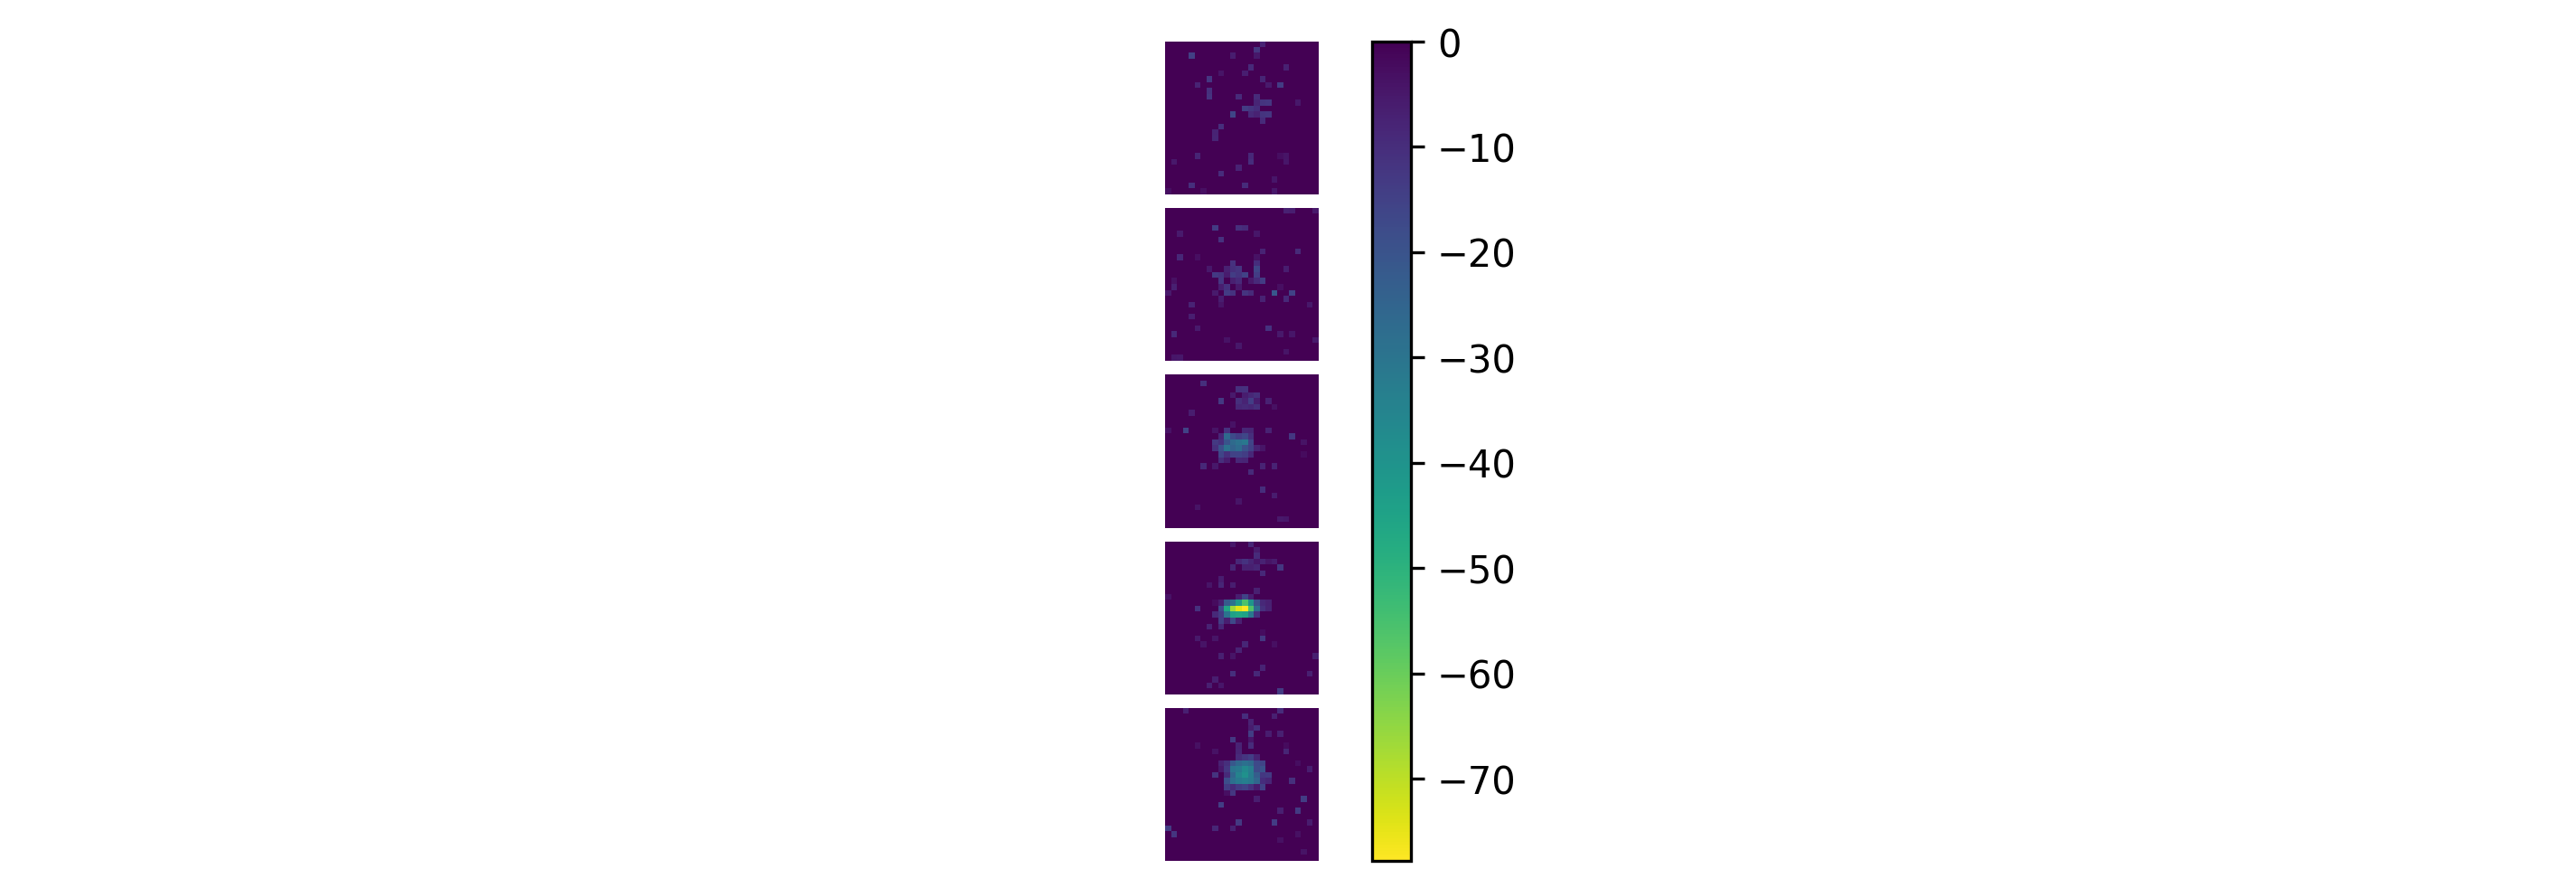

In [5]:
data_path = '220311_cell1_emx_multigrid_A_grid_multispot_variational_sns_results.pkl'

with open(data_path, 'rb') as f:
    ms_results = np.load(f, allow_pickle='True')
    
est_weights_multispot = -ms_results['multispot_model'].state['mu'].reshape(1,26,26,5)
fig = plt.figure(figsize=(12, 4), dpi=300, facecolor='white')
plot_multi_means(fig, [est_weights_multispot], np.arange(5))



In [5]:

powers

stim_matrix.shape

(10000, 3380)

In [6]:
## Check Denoiser results
from sklearn.linear_model import Lasso

lasso_weights_denoised = np.zeros((2, 26, 26, 5))
lasso_weights_raw = np.zeros((2, 26, 26, 5))
stim_matrix = ms_results['multispot_stim'].T
powers = np.unique(stim_matrix)[1:]
alphas = [1e-3, 1e-3]

for power_idx, power in enumerate(powers):
    # get rows containing a certain value
    curr_idxs = np.any(stim_matrix == power, axis=1)
    stim_curr = stim_matrix[curr_idxs,:]
    
    A = stim_curr > 0 
    y_den = ms_results['multispot_den_psc'][curr_idxs,:].sum(axis=1)
    y_raw = ms_results['multispot_psc'][curr_idxs,:].sum(axis=1)

    lasso = Lasso(alpha=alphas[power_idx], positive=True)
    lasso.fit(A, y_den)
    den_result_curr = lasso.coef_.reshape(26, 26, 5)
    lasso_weights_denoised[power_idx,...] = den_result_curr
    

    # redo with raw traces
    lasso.fit(A, y_raw)
    raw_result_curr = lasso.coef_.reshape(26, 26, 5)
    lasso_weights_raw[power_idx,...] = raw_result_curr
    
    

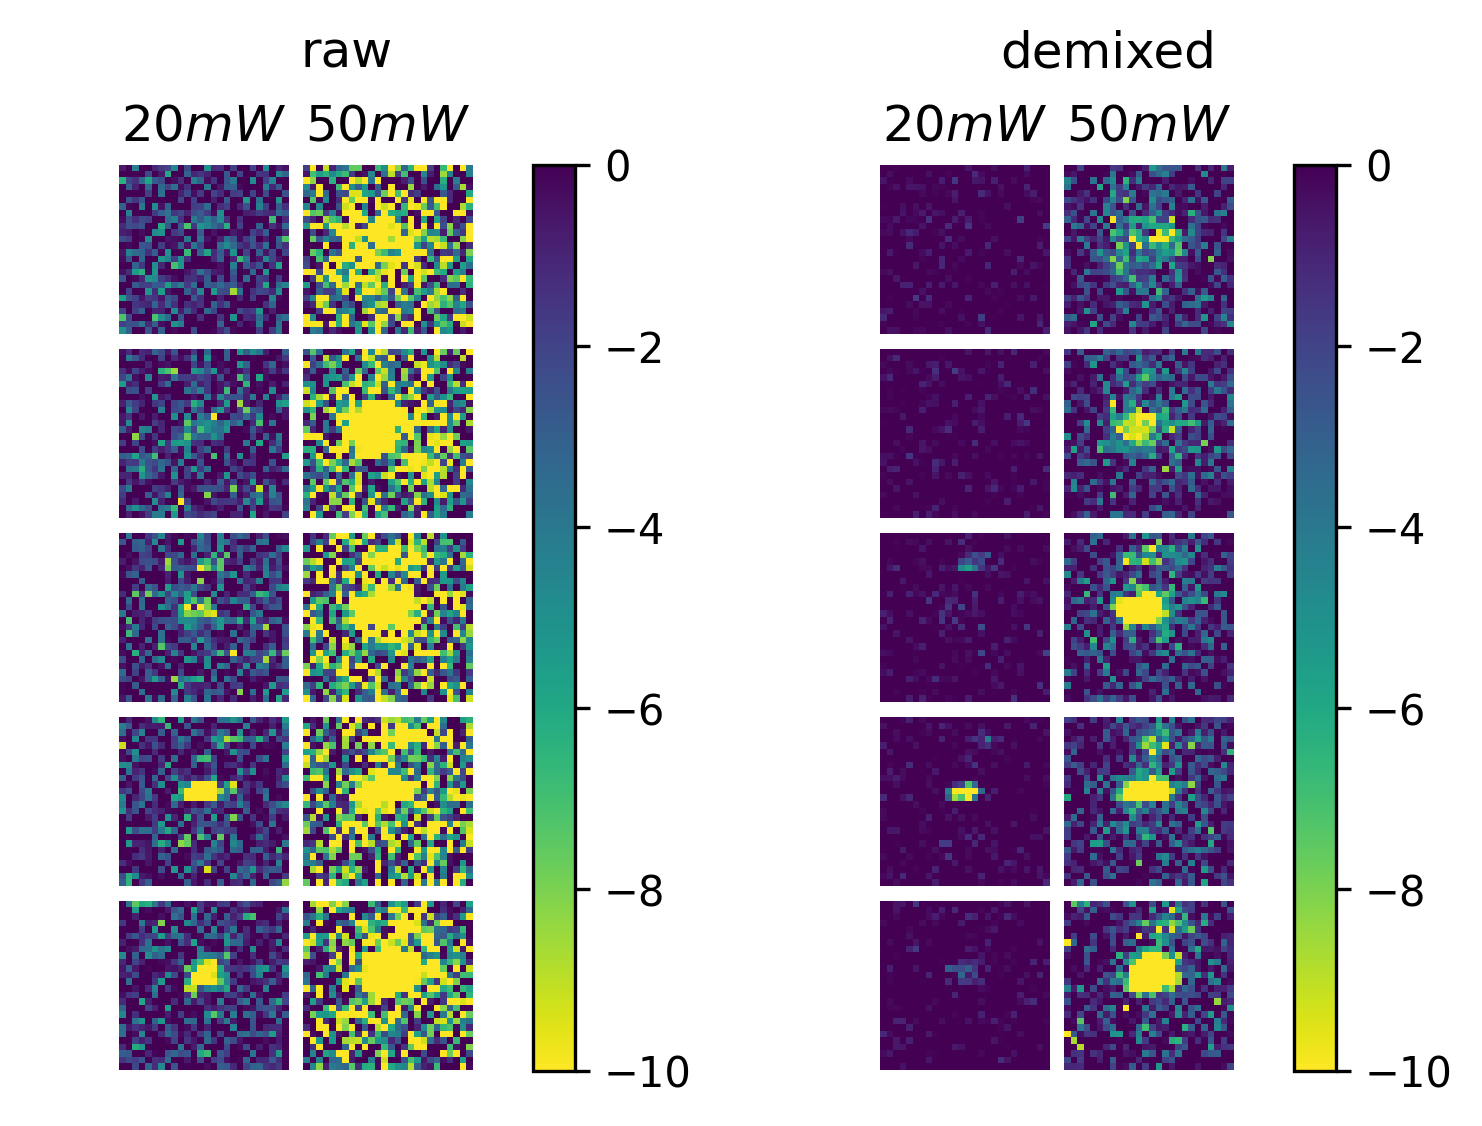

In [7]:
fig = plt.figure(figsize=(6, 4), dpi=300, facecolor='white')
plot_multi_means(fig,
                 [-lasso_weights_raw, -lasso_weights_denoised],
                 np.arange(5), powers=powers,
                 map_names=['raw', 'demixed'])



IndexError: boolean index did not match indexed array along dimension 0; dimension is 10000 but corresponding boolean dimension is 5000

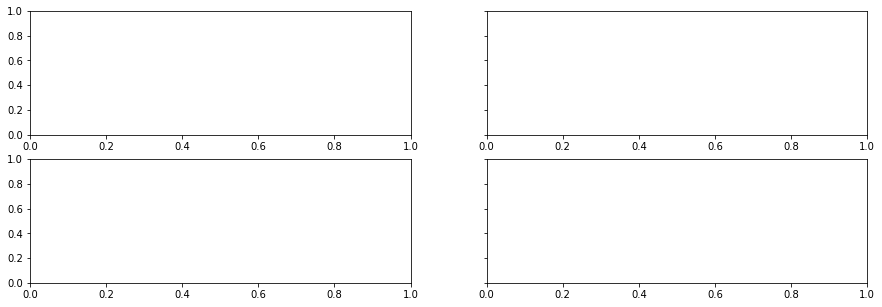

In [101]:
threshold = 5.0
sorted_idxs = np.argsort(y_den[nonzeros])
num_to_plot = 10

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,5), sharey=True)

for power_idx, power in enumerate(powers):
    # get rows containing a certain value
    curr_idxs = np.any(stim_matrix == power, axis=1)
    
    y_den = ms_results['multispot_den_psc'][curr_idxs,:].sum(axis=1)
    y_raw = ms_results['multispot_psc'][curr_idxs,:].sum(axis=1)
    nonzeros = y_den > threshold

    den_pscs_nonzero = ms_results['multispot_den_psc'][nonzeros]
    raw_pscs_nonzero = ms_results['multispot_psc'][nonzeros]

    axs[0,power_idx].plot(den_pscs_nonzero[sorted_idxs[0:num_to_plot],:].T)
    axs[0,power_idx].plot(raw_pscs_nonzero[sorted_idxs[0:num_to_plot],:].T)




# Multispot/Singlespot Alignment


In [23]:
from sklearn.linear_model import Ridge

def plot_spike_inference_single_vs_multi(den_single, den_multi, model_single, model_multi, stim_single, stim_multi, 
                                         I_single, I_multi, save=None, ymax=None, n_plots=15, max_trials_to_show=30, 
                                         trial_len=900, col_width=7.5, row_height=0.6, order=None, fontsize=14,
                                         true_weights=None):
    N = model_single.n_presynaptic
    K = den_single.shape[0]

    if ymax is None:
        ymax = np.percentile(den_multi/np.max(den_multi), 99.99)
    ymin = -0.05 * ymax
    
    lam_single = model_single.state['lam']
    mu_single = np.copy(model_single.state['mu'])
    if 'z' in model_single.state.keys():
        z_single = model_single.state['z']
    else:
        z_single = np.zeros(K)
    
    lam_multi = model_multi.state['lam']
    mu_multi = np.copy(model_multi.state['mu'])
    if 'z' in model_multi.state.keys():
        z_multi = model_multi.state['z']
    else:
        z_multi = np.zeros(K)
    
    mu_normalised_single = mu_single/np.max(mu_single)
    mu_normalised_multi = mu_multi/np.max(mu_multi)
    mu_order_single = np.argsort(mu_single)[::-1]

    # If no order is specified, sort by increasing order of single-target
    # inferred weights
    if order is None:
        order = mu_order_single.copy()
        
    # PSC inference
    lr = Ridge(fit_intercept=False, alpha=1e-3)
    lr.fit((lam_multi * (lam_multi >= 0.5)).T, den_multi)
    coef_multi = lr.coef_.T

    lr.fit((lam_single * (lam_single >= 0.5)).T, den_single)
    coef_seq = lr.coef_.T
    
    # Plotting params
    num_trials_single = np.sum(stim_single[0] > 0)
    num_trials_multi = max_trials_to_show

    fig = plt.figure(figsize=((1 + num_trials_multi/num_trials_single) * col_width, row_height * n_plots * 1.5), facecolor='white')
    gs = fig.add_gridspec(ncols=3, nrows=n_plots, hspace=0.5, wspace=0.05, width_ratios=[1, 1/num_trials_single, num_trials_multi/num_trials_single])
    
    normalisation_factor = np.max(np.abs(den_single))
    trace_linewidth = 0.65
    
    ###  Single-target responses  ###
    for m in range(n_plots):
        n = order[m]
        
        # spike predictions
        ax = fig.add_subplot(gs[m, 0])
        if m == 0:
            plt.title('Single target', fontsize=fontsize, y=1.5)
        stim_locs_unsrt = np.where(stim_single[n] > 0)[0]
        stim_locs = stim_locs_unsrt[np.argsort(I_single[stim_locs_unsrt])]
        this_y_psc = den_single[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs_unsrt), max_trials_to_show])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)
        
        plt.xlim([0, trial_len*n_repeats])
        trace_col = 'k' if mu_single[n] != 0 else 'gray'
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            if not np.isnan(mu_normalised_single[n]):
                ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                                 edgecolor='None', alpha=lam_single[n, stim_locs][tb] * mu_normalised_single[n], zorder=-5)
            
            if z_single[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.75 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)
                        
            # Plot power changes
            if (m == 0) and (I_single[stim_locs][tb] != I_single[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I_single[stim_locs][tb], fontsize=fontsize-2)
                
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
        if true_weights is not None:
            label_col = 'k' if true_weights[n] != 0 else 'gray'
        else:
            label_col = 'k'
        plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center', color=label_col)

        ax.set_rasterization_zorder(-2)
        
    ### Inferred PSC waveforms ###
    for m in range(n_plots):
        n = order[m]
        
        ax = fig.add_subplot(gs[m, 1])
        
        plt.plot(coef_seq[n]/normalisation_factor, color='gray', linewidth=trace_linewidth)
        plt.plot(coef_multi[n]/normalisation_factor, color='k', linewidth=trace_linewidth)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
        
    ###  Multi-target responses  ###
    for m in range(n_plots):
        n = order[m]
        
        
        # spike predictions
        ax = fig.add_subplot(gs[m, 2])
        if m == 0:
            plt.title('Multi target', fontsize=fontsize, y=1.5)
        
        powers = np.unique(I_multi)
        trials_per_power = num_trials_multi // len(powers)
        stim_locs = np.array([])
        for pwr in powers:
            stim_locs = np.concatenate([stim_locs, np.where(stim_multi[n] == pwr)[0][:trials_per_power]])
        
        stim_locs = stim_locs.astype(int)
        this_y_psc = den_multi[stim_locs].flatten()/normalisation_factor
        n_repeats = np.min([len(stim_locs), max_trials_to_show])
        trial_breaks = np.arange(0, trial_len * n_repeats + 1, trial_len)

        plt.xlim([0, trial_len*n_repeats])
        trace_col = 'k' if mu_multi[n] != 0 else 'gray'
        facecol = 'firebrick'
        for tb in range(len(trial_breaks) - 1):
            if tb > 0:
                plt.plot([trial_breaks[tb], trial_breaks[tb]], [ymin, ymax], '--', color=trace_col)
                
            ax.fill_between(np.arange(trial_len * tb, trial_len * (tb + 1)), ymin * np.ones(trial_len), ymax * np.ones(trial_len), facecolor=facecol, 
                             edgecolor='None', alpha=lam_multi[n, stim_locs][tb] * mu_normalised_multi[n], zorder=-5)
            
            if z_multi[stim_locs][tb] != 0:
                plt.plot(trial_len * (tb + 0.5), 0.9 * ymax, marker='*', markerfacecolor='b', markeredgecolor='None', markersize=6)

            # Plot power changes
            if (m == 0) and (I_multi[stim_locs][tb] != I_multi[stim_locs][tb-1]):
                plt.text(trial_breaks[tb], 1.1 * ymax, '%i mW'%I_multi[stim_locs][tb], fontsize=fontsize-2)
            
            # Annotate estimated spiking cells
            
            inferred_spiking_cells = np.where(model_multi.state['lam'][:, stim_locs][:, tb] >= 0.5)[0]
            
            
                
            annotated_cells = np.intersect1d(inferred_spiking_cells, np.where(mu_multi != 0)[0])
            annotated_locs = np.array([np.where(order == i)[0][0] + 1 for i in annotated_cells])
            plt.text(trial_breaks[tb], -0.3, ','.join(annotated_locs.astype(str).tolist()), fontsize=7)
            
            # debugging: find cells which spike, but are labeled neither as sponts nor as assigned spikes
            if (inferred_spiking_cells.size > 0) and (annotated_locs.size == 0): 
                import pdb; pdb.set_trace()   
                    
        plt.plot(this_y_psc, color=trace_col, linewidth=trace_linewidth)
        
        for loc in ['top', 'right', 'left', 'bottom']:
            plt.gca().spines[loc].set_visible(False)
        plt.xticks([])
        plt.yticks([])
        plt.ylim([ymin, ymax])
#         plt.ylabel(m+1, fontsize=fontsize-1, rotation=0, labelpad=15, va='center')

        ax.set_rasterization_zorder(-2)
    
    if save is not None:
        plt.savefig(save, format='png', bbox_inches='tight', dpi=200, facecolor='white')
    plt.show()

**Hack for multi-spot grids**:  
For multi-spot grid data, we typically don't have corresponding single-spot maps for _every_ point. Instead, we only have the corresponding single-spot map for a single plane.  

In order to make the `plot_spike_inference_single_vs_multi` function work, we create a dummy multi-spot model which only has the plane we care above.


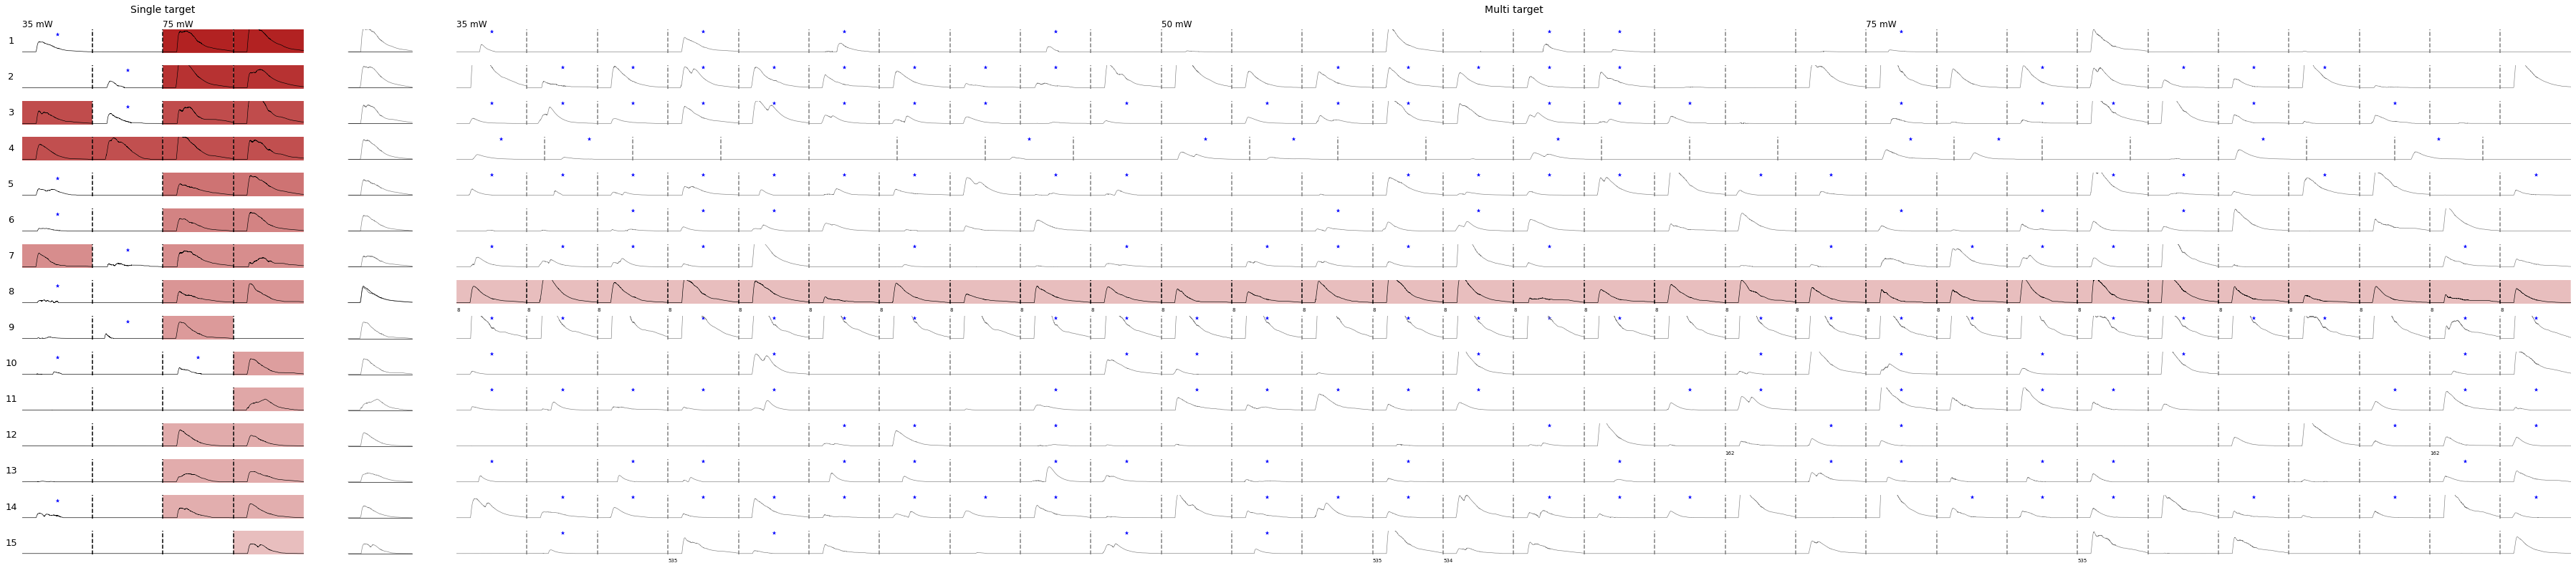

In [24]:
def make_dummy_multispot_params(multispot_model, multispot_stim, multispot_psc, plane_keep_idx=3, grid_dims=(26,26,5)):
    dummy_model = adaprobe.Model(N=multispot_model.n_presynaptic,
                                model_type=multispot_model.model_type,
                                priors=multispot_model.priors)
    
    # calculate which idx we want to keep:
    # we create a dummy array the same shape as the grid and then use 
    # np.where to get the indices for a single plane.
    grid = np.zeros(grid_dims)
    grid[:,:,plane_keep_idx] = 1
    cell_idx_keep = np.where(grid.ravel())[0]

    # get relevant trial indices using stim matrix
    stim_multi = multispot_stim[cell_idx_keep, :]
    trial_idx_keep = np.sum(stim_multi, axis=0) != 0
    stim_multi = stim_multi[:,trial_idx_keep]
    
    # subsample along cells dimension and trials dimension
    dummy_model.state['lam'] = multispot_model.state['lam'][cell_idx_keep,:][:,trial_idx_keep]
    dummy_model.state['mu'] = multispot_model.state['mu'][cell_idx_keep]
    dummy_model.state['z'] = multispot_model.state['z'][trial_idx_keep]
    den_multi = multispot_psc[trial_idx_keep,:]
    
    return dummy_model, stim_multi, den_multi

# make variables required for checkerboards
den_single = results['singlespot_den_psc']
den_multi = results['multispot_den_psc']
model_single = results['singlespot_model']

# make reduced multi-spot model and stim
stim_multi = results['multispot_stim']
model_multi, stim_multi, den_multi = make_dummy_multispot_params(
    results['multispot_model'], stim_multi, den_multi, plane_keep_idx=3)
stim_single = results['singlespot_stim']

# create I vectors from stim matrix
I_single = np.sum(stim_single, axis=0) / np.sum(stim_single != 0, axis=0)
I_multi = np.sum(stim_multi, axis=0) / np.sum(stim_multi != 0, axis=0)

# make checkerboard fig
plot_spike_inference_single_vs_multi(den_single,
                                     den_multi,
                                     model_single,
                                     model_multi,
                                     stim_single,
                                     stim_multi,
                                     I_single,
                                     I_multi,
)

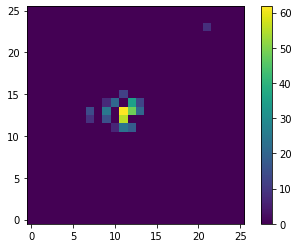

In [13]:
plt.imshow(model_multi.state['mu'].reshape(26,26), origin='lower')
plt.colorbar()

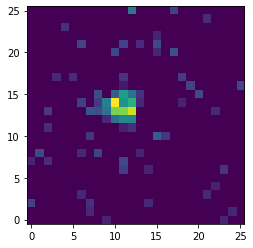

In [15]:
plt.imshow(model_single.state['mu'].reshape(26,26).T, origin='lower')


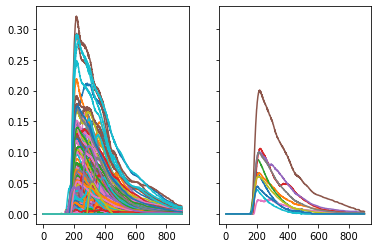

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
trial_idx_no_spikes = np.where(model_multi.state['lam'][296,:] <= 0.5)[0]
trial_idx_spikes = np.where(model_multi.state['lam'][296,:] > 0.5)[0]

axs[0].plot(den_multi[trial_idx_no_spikes[0:500]].T)
axs[1].plot(den_multi[trial_idx_spikes[0:500]].T)
plt.show()

In [45]:
trial_idx_no_spikes = np.where(model_multi.state['lam'][296,:] <= 0.5)[0]
trial_idx_spikes = np.where(model_multi.state['lam'][296,:] > 0.5)[0]
